In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 2.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")

Current default figure size: [3.5, 2.625]
New default figure size: [8.75, 6.5625]


In [2]:
# Generate non-linear data
def generate_2d_sinusoidal_data(N, M, num_samples):
    data = []
    for _ in range(num_samples):
        x = np.linspace(0, 1, N)
        y = np.linspace(0, 1, M)
        xx, yy = np.meshgrid(x, y)

        # Random phase shifts for x and y directions
        phase_shift_x = np.random.uniform(0, 2 * np.pi)
        phase_shift_y = np.random.uniform(0, 2 * np.pi)

        # Random frequency multipliers for x and y directions
        freq_multiplier_x = np.random.uniform(0.5, 1.5)
        freq_multiplier_y = np.random.uniform(0.5, 1.5)

        # Generate sinusoidal data with random phase and frequency
        z = np.sin(2 * np.pi * freq_multiplier_x * xx + phase_shift_x) * np.cos(
            2 * np.pi * freq_multiplier_y * yy + phase_shift_y)
        data.append(z)

    return np.array(data).astype(np.float32)

In [3]:
class DenseAutoEncoder(nn.Module):
    """
    Base autoencoder neural principal latent components decomposition model.
    """

    def __init__(self, input_dim: int | list | tuple, latent_dim: int, hidden_dim: int | list | tuple, num_layers=3,
                 act_fn=nn.Mish):
        super().__init__()
        # check if input_dim is instance of iterable in such a case take the first argument only
        if isinstance(input_dim, (list, tuple)):
            input_dim = input_dim[0]

        self.latent_dim = latent_dim
        layers_encoder = []
        if not isinstance(hidden_dim, (list, tuple)):
            hidden_dim = [hidden_dim] * num_layers
        elif len(hidden_dim) != num_layers:
            warnings.warn("The hidden_dim is an iterable, the length of hidden_dim must be equal to num_layers."
                          " Setting it to [hidden_dim] * num_layers.")
            num_layers = len(hidden_dim)

        assert len(hidden_dim) == num_layers, "The length of hidden_dim must be equal to num_layers."

        layer = nn.Linear(input_dim, hidden_dim[0])       

        layers_encoder.append(layer)
        layers_encoder.append(act_fn())
        for i in range(1, num_layers):
            layer = nn.Linear(hidden_dim[i - 1], hidden_dim[i])                      
            layers_encoder.append(layer)           
            layers_encoder.append(act_fn())

        layer = nn.Linear(hidden_dim[-1], latent_dim)       
        layers_encoder.append(layer)

        self.encoder = nn.Sequential(*layers_encoder)

        layers_decoder = []
        reversed_hidden_dim = hidden_dim[::-1]
        layer = nn.Linear(latent_dim, reversed_hidden_dim[0])       

        layers_decoder.append(layer)      
        for i in range(1, num_layers):
            layer = nn.Linear(reversed_hidden_dim[i - 1], reversed_hidden_dim[i],bias=False)                      
            layers_decoder.append(layer)                     

        layer = nn.Linear(reversed_hidden_dim[-1], input_dim,bias=False)       
        layers_decoder.append(layer)
        self.decoder = nn.Sequential(*layers_decoder)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction
        

In [4]:
N, M = 20, 40
data = generate_2d_sinusoidal_data(N, M, 1000)
data = np.squeeze(data.reshape(data.shape[0], -1))
data.shape

(1000, 800)

In [5]:
# Convert to PyTorch tensors
x_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(data, dtype=torch.float32)
x_tensor.shape, y_tensor.shape

(torch.Size([1000, 800]), torch.Size([1000, 800]))

In [18]:
# Initialize model, criterion, and optimizer
model = DenseAutoEncoder(input_dim=x_tensor.shape[1:], latent_dim=30, hidden_dim=[512,256,128,64,32], num_layers=5, act_fn=nn.SiLU)
model

DenseAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): SiLU()
    (10): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=False)
    (2): Linear(in_features=64, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=256, bias=False)
    (4): Linear(in_features=256, out_features=512, bias=False)
    (5): Linear(in_features=512, out_features=800, bias=False)
  )
)

In [7]:
device = torch.device("cpu")
model.to(device)
x_tensor = x_tensor.to(device)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 10000
epoch_progress = tqdm(range(num_epochs), desc="epoch", leave=True, total=num_epochs)        
for epoch in epoch_progress:
    model.train()
    optimizer.zero_grad()
    reconstructed = model(x_tensor)
    loss = criterion(reconstructed, x_tensor)
    loss.backward()
    optimizer.step()    
    epoch_progress.set_postfix({"reconstruction_loss": loss.item()})

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

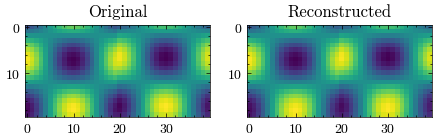

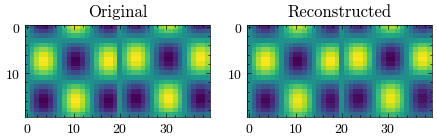

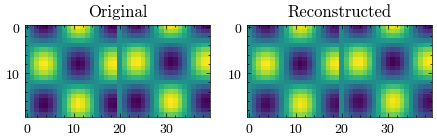

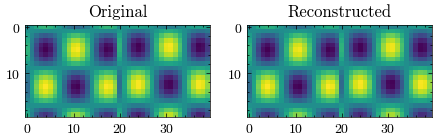

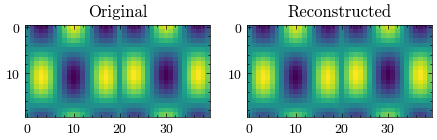

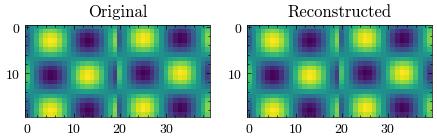

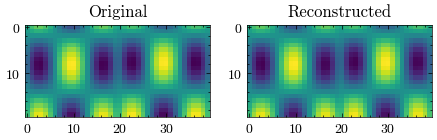

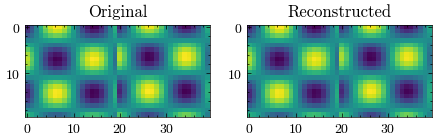

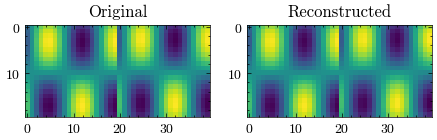

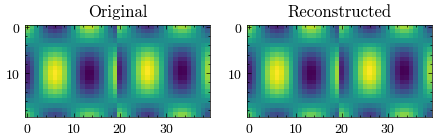

In [13]:
for i in range(10):
    # Plot original and reconstructed signals for a sample
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(data[i].reshape(N,M), cmap="viridis")
    axes[0].set_title("Original")
    axes[1].imshow(model(x_tensor[i]).detach().cpu().numpy().reshape(N,M), cmap="viridis")
    axes[1].set_title("Reconstructed")
    plt.show()

In [14]:
def get_test_data(model, test_data, num_samples):
    """
    Prepare test data for linear mapping property evaluation.
    
    Args:
    model: The encoder model to be tested.
    test_data: The original test dataset.
    num_samples: Number of samples to use for testing.
    
    Returns:
    x, y: Encoded test samples.
    """
    model.eval()
    num_samples = min(test_data.shape[0], num_samples)
    indices = np.random.choice(test_data.shape[0], num_samples, replace=False)
    x_samples = test_data[indices]
    y_samples = test_data[np.random.choice(test_data.shape[0], num_samples, replace=False)]
    
    with torch.no_grad():
        x = model(x_samples)
        y = model(y_samples)
    
    return x, y

In [21]:
def evaluate_and_plot(model, x, y):
    """
    Evaluate the linear properties of additivity and homogeneity of a given model and plot the results.
    
    This function tests if a model maintains linear properties:
    1. **Additivity**: Checks if the model satisfies f(x + y) ≈ f(x) + f(y).
    2. **Homogeneity**: Checks if the model satisfies f(αx) ≈ αf(x).

    Linear properties are essential for ensuring that a model behaves predictably under linear transformations.
    This function helps to verify if the model exhibits such behavior, which is crucial for applications
    requiring linear consistency.

    Args:
        model: A PyTorch model to be tested. The model should be designed to accept and output tensors
               of shape (batch_size, n*m).
        x (torch.Tensor): Input tensor of shape (batch_size, n, m) representing the first set of samples.
        y (torch.Tensor): Input tensor of shape (batch_size, n, m) representing the second set of samples.

    Returns:
        additivity_corr (float): Correlation coefficient for additivity, indicating the degree of linearity
                                 in the additivity property.
        homogeneity_corr (float): Correlation coefficient for homogeneity, indicating the degree of linearity
                                  in the homogeneity property.

    Steps:
    1. Reshape inputs `x` and `y` to 2D tensors (batch_size, n*m) for compatibility with the model's linear layers.
    2. Define a function `f` that processes input through the model and reshapes the output back to (batch_size, n*m).
    3. Compute model outputs for additivity and homogeneity tests:
        a. **Additivity**: Evaluate `f(x + y)` and compare with `f(x) + f(y)`.
        b. **Homogeneity**: Evaluate `f(αx)` and compare with `αf(x)`.
    4. Flatten results to 1D arrays for correlation calculation.
    5. Calculate correlation coefficients for additivity and homogeneity to quantify linearity.
    6. Plot the results:
        a. Scatter plot for additivity with a correlation coefficient.
        b. Scatter plot for homogeneity with a correlation coefficient and a color bar for α values.

    Detailed Steps and Logic:
    """

    # Set the model to evaluation mode
    model.eval()
    shape = x.shape
    num_samples = shape[0]
    
    # Reshape inputs to 2D tensors (batch_size, n*m) for model compatibility
    x = x.view(num_samples, -1)
    y = y.view(num_samples, -1)
    
    def f(x):
        """
        Process input through the model and reshape output to (batch_size, n*m).
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n*m).
        
        Returns:
            torch.Tensor: Model output of shape (batch_size, n*m).
        """
        return model(x).detach().view(num_samples, -1)
    
    with torch.no_grad():
        # Test Additivity
        # Evaluate f(x + y)
        xx = f(x + y)
        fx_shape = xx.shape  # Store the shape for use in the homogeneity test

        # Evaluate f(x) + f(y)
        yy = f(x) + f(y)

        # Flatten tensors to 1D arrays for correlation calculation
        xx = xx.cpu().numpy().flatten()
        yy = yy.cpu().numpy().flatten()

        # Calculate correlation coefficient for additivity
        additivity_corr = np.corrcoef(xx, yy)[0, 1]

        # Test Homogeneity
        # Generate alpha values between -1 and 1
        alpha = torch.linspace(-1, 1, steps=num_samples, device=x.device).unsqueeze(1)
        
        # Evaluate f(αx)
        xx_alpha = f(alpha * x)  # Multiply input x by alpha and pass through the model

        # Repeat alpha values to match the shape of f(x)
        alpha = alpha.repeat(1, fx_shape[1])

        # Evaluate αf(x)
        yy_alpha = alpha * f(x)

        # Flatten tensors to 1D arrays for correlation calculation
        xx_alpha = xx_alpha.cpu().numpy().flatten()
        yy_alpha = yy_alpha.cpu().numpy().flatten()
        alpha_colors = alpha.cpu().numpy().flatten()

        # Calculate correlation coefficient for homogeneity
        homogeneity_corr = np.corrcoef(xx_alpha, yy_alpha)[0, 1]
    
    # Plotting the results
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Additivity plot
    ax1.scatter(xx, yy, alpha=0.7, s=1)
    min_val = min(xx.min(), yy.min())
    max_val = max(xx.max(), yy.max())
    ax1.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)
    ax1.set_xlabel(r"$f(x + y)$")
    ax1.set_ylabel(r"$f(x) + f(y)$")
    ax1.set_title(f"Additivity\nCorrelation: {additivity_corr:.4f}")
    ax1.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
    ax1.axvline(x=0, color='k', linestyle=':', linewidth=0.5)
    ax1.set_aspect("equal")
    
    # Homogeneity plot
    scatter = ax2.scatter(xx_alpha, yy_alpha, c=alpha_colors, cmap='coolwarm', alpha=0.7, s=1)
    min_val = min(xx_alpha.min(), yy_alpha.min())
    max_val = max(xx_alpha.max(), yy_alpha.max())
    ax2.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)
    ax2.set_xlabel(r"$f(\alpha x)$")
    ax2.set_ylabel(r"$\alpha f(x)$")
    ax2.set_title(f"Homogeneity\nCorrelation: {homogeneity_corr:.4f}")
    ax2.set_aspect("equal")

    # Add colorbar for alpha values
    cbar = fig.colorbar(scatter, ax=ax2, fraction=0.04, label=r"$\alpha$ values")
    
    ax2.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
    ax2.axvline(x=0, color='k', linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return additivity_corr, homogeneity_corr

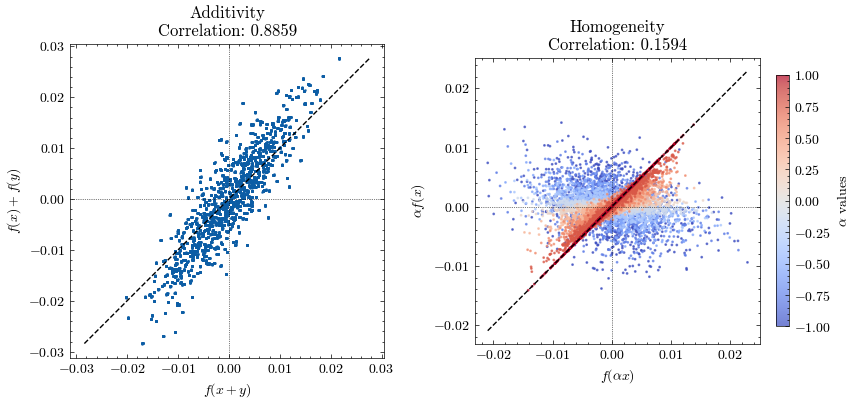

In [24]:
# Usage example:
x, y = get_test_data(model.encoder, x_tensor, num_samples=10)
additivity_corr, homogeneity_corr = evaluate_and_plot(model.decoder, x, y)